# 2. Multi-Armed Bandit, MAB 多臂老虎机

## 2.2. Introduction

### 2.2.1. Definiton
### 2.2.2 Formal Description
  - $\mathcal{A}$: 动作集合，假设共有$K$个拉杆：
    - $\mathcal{A} = \{a_1, ......, a_K\}, a_t \in \mathcal{A}$
  - $\mathcal{R}$: 奖励概率分布，
    - 拉动一根拉杆的动作a对应一个奖励概率分布 $\mathcal{R}(r|a)$
  - 优化目标：
    - $\max\sum_{t=1}^Tr_t, r_t \sim \mathcal{R}(\cdot | a_t)$
  - 下标$t$, 时刻。
### 2.2.3. Cummulative Regret: 累计懊悔 
  - 期望奖励$Q(a) = \mathbb{E}_{r \sim \mathcal{R}(\cdot | a)} [r]$
  - 最优期望奖励$Q^* = \max_{a \in \mathcal{A}}Q(a)$, 
    - 注意存在唯一一根拉杆她的期望奖励不小于其他任何一个，
    - 所以最优解就是一直拉她就可以了
    - 难点就是找到她
  - 懊悔（regret）： $R(a) = Q^* - Q(a)$
  - 累计懊悔：$\sigma_R = \sum_{t=1}^TR(a_t)$
  - MAB目标<=> 最小化累计懊悔

### 2.2.4. 估计期望奖励

伪代码：
1. 对所有$a \in \mathcal{A}$, 
2. init: 
   1. $N(a) = 0$ # 计数器
   2. $\hat{Q}(a) = 0$ # 期望估计值
3.  **for** $t = 1 \rightarrow T$ **do**
    1.  选取拉杆拉动，记为$a_t$
    2.  得到奖励$r_t$
    3.  更新计数器：$N(a_t) = N(a_t) + 1$
    4.  更新奖励期望估计： $\hat{Q}(a_t) = \hat{Q}(a_t) + \frac1{N(a_t)}[r_t - \hat{Q}(a_t)]$
4.  **end for**

`3.4`.作如下理解
$$
\begin{aligned}
Q_k &= \frac1k\sum_{i=1}^kr_i \\
    &= \frac1k(r_k + \sum_{i=1}^{k - 1}r_i) \\
    &= \frac1k(r_k + (k - 1)Q_{k-1}) \\
    &= \frac1k(r_k + kQ_{k-1} - Q_{k-1}) \\
    &= Q_{k-1} + \frac1k[r_k - Q_{k-1}]
\end{aligned}
$$


In [1]:
# 环境构建
import numpy as np 
import matplotlib.pyplot as plt

class BernouliBandit:
  """伯努利多臂老虎机，拉杆K个"""
  def __init__(self, K):
    self.probs = np.random.uniform(size=K) 
    # 随机获得K个0-1的数值，作为拉杆奖励的获奖
    self.best_idx = np.argmax(self.probs) # 获奖概率最大的拉杆
    self.best_prob = self.probs[self.best_idx] # 最大获奖概率
    self.K = K
    
  def step(self, k):
    # 当玩家选择了k号拉杆后,
    # 根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未获奖）
    if np.random.rand()< self.probs[k]:
      return 1
    else:
      return 0
    
np.random.seed(1)
K = 10
bandit_10_arm = BernouliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
  (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


In [2]:
class Solver:
  """ 多臂老虎机算法基本框架 """
  def __init__(self, bandit):
    self.bandit = bandit
    self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
    self.regret = 0.  # 当前步的累积懊悔
    self.actions = []  # 维护一个列表,记录每一步的动作
    self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

  def update_regret(self, k):
    # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
    self.regret += self.bandit.best_prob - self.bandit.probs[k]
    self.regrets.append(self.regret)

  def run_one_step(self):
    # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
    raise NotImplementedError

  def run(self, num_steps):
    # 运行一定次数,num_steps为总运行次数
    for _ in range(num_steps):
      k = self.run_one_step()
      self.counts[k] += 1
      self.actions.append(k)
      self.update_regret(k)

## 2.3. Exploration and Exploitation: 探索与利用

## 2.4. $\epsilon$贪心

$$
a_t = \left\{ 
  \begin{aligned}
  \argmax_{a\in\mathcal{A}} \hat{Q}(a), &采样概率: 1 - \epsilon \\
  从\mathcal{A}\text{随机选择}，&采样概率：\epsilon
  \end{aligned}
  \right.
$$

In [3]:
class EpsilonGreedy(Solver):
  """ epsilon贪婪算法,继承Solver类 """
  def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
    super(EpsilonGreedy, self).__init__(bandit)
    self.epsilon = epsilon
    #初始化拉动所有拉杆的期望奖励估值
    self.estimates = np.array([init_prob] * self.bandit.K)

  def run_one_step(self):
    if np.random.random() < self.epsilon:
      k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
    else:
      k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
    r = self.bandit.step(k)  # 得到本次动作的奖励
    self.estimates[k] += \
      1. / (self.counts[k] + 1) * (r - self.estimates[k])
    return k

epsilon-贪婪算法的累积懊悔为： 25.526630933945313


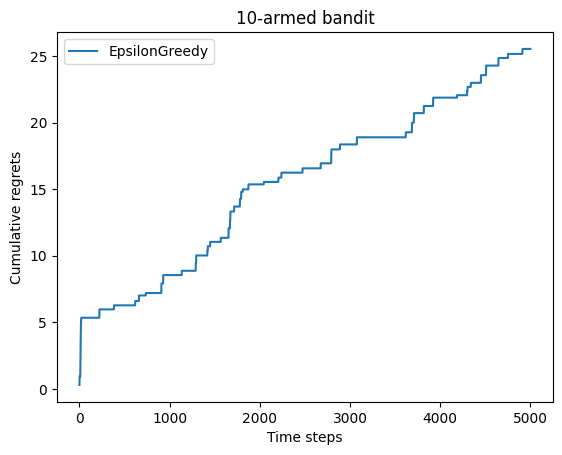

In [4]:
def plot_results(solvers, solver_names):
  """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
  而solver_names也是一个列表,存储每个策略的名称"""
  for idx, solver in enumerate(solvers):
    time_list = range(len(solver.regrets))
    plt.plot(time_list, solver.regrets, label=solver_names[idx])
  plt.xlabel('Time steps')
  plt.ylabel('Cumulative regrets')
  plt.title('%d-armed bandit' % solvers[0].bandit.K)
  plt.legend()
  plt.show()


np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

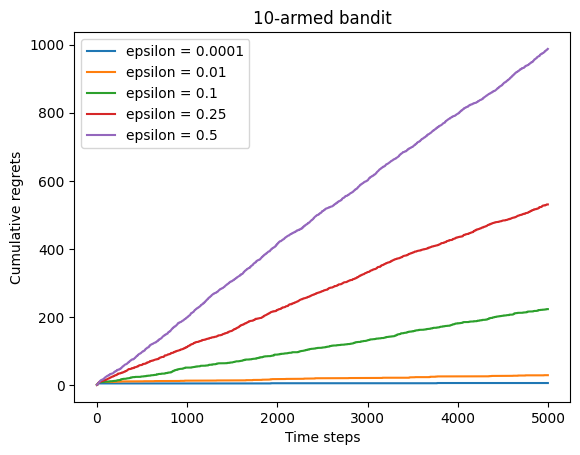

In [5]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
  EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon = {}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
  solver.run(5000)
  
plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

我们需要设法让$\epsilon$随时间减少

epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183


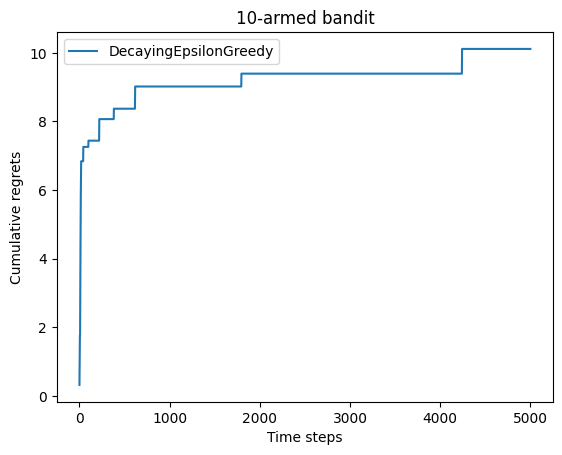

In [6]:
class DecayingEpsilonGreedy(Solver):
  """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
  def __init__(self, bandit, init_prob=1.0):
    super(DecayingEpsilonGreedy, self).__init__(bandit)
    self.estimates = np.array([init_prob] * self.bandit.K)
    self.total_count = 0

  def run_one_step(self):
    self.total_count += 1
    if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
      k = np.random.randint(0, self.bandit.K)
    else:
      k = np.argmax(self.estimates)

    r = self.bandit.step(k)
    self.estimates[k] += \
      1. / (self.counts[k] + 1) * (r - self.estimates[k])
    return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

## 2.5. Upper Confidence Bound (UCB): 上置信界算法

根据霍夫丁不等式（Hoeffding's ineq.）， $\{X_i\}_i=1^n \in [0, 1]$ i.i.d, 有 
$$
\mathbb{P}\{\mathbb{E}[X] \geq \bar{x}_n + u\} \leq e^{-2nu^2}
$$

$\hat{Q}_t(a)$带入$\bar{x}_t$, 相应的$u = \hat{U}_t(a)$, 给定概率$p = e^{-2N_t(a)U_t(a)^2}$, 则$Q_t(a) < \hat{Q}_t(a) + \hat{U}_t(a)$ 以概率$1 - p$成立，

$p$越小，上式的右侧就越构成奖励期望的上界，于是UCB选择奖励期望上界最大的动作，i.e. $a = \argmax_{a\in\mathbb{A}}[\hat{Q}(a) + \hat{U}(a)]$, 其中$\hat{U}_t(a) = \sqrt{\frac{-log p}{2 N_t(a)}}$

具体实现我们设置$p = \frac1t$, 且$\hat{U}_t(a) = \sqrt{\frac{-log p}{2 N_t(a) + 1}}$以免出现/0问题，最后，设置系数$c$控制不确定性比重$a = \argmax_{a\in\mathbb{A}}[\hat{Q}(a) + c\hat{U}(a)]$

上置信界算法的累积懊悔为： 70.45281214197854


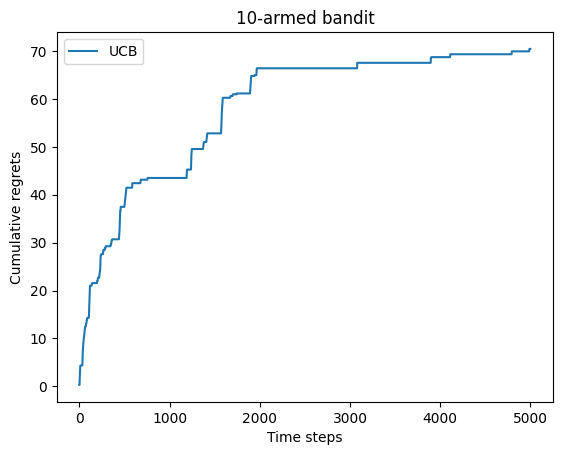

In [7]:
class UCB(Solver):
  def __init__(self, bandit, coef, init_prob = 1.0):
    super(UCB, self).__init__(bandit)
    self.total_count = 0
    self.estimates = np.array([init_prob] * self.bandit.K)
    self.coef = coef
  def run_one_step(self):
    self.total_count += 1
    ucb = self.estimates + self.coef * \
      np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))
    # 计算上置信界
    k = np.argmax(ucb) # 选择最大
    r = self.bandit.step(k)
    self.estimates[k] += \
      1. / (self.counts[k] + 1) * (r - self.estimates[k])
    return k  
  
np.random.seed(1)
coef = 1
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

## 2.6. 汤普森采样
对每个杆进行Beta分布建模（某杆被拉$k$次，$m_1$奖励1，$m_2$奖励0, 假设拉杆奖励服从$\Beta(m_1 + 1, m_2 + 1)$, 再依次选择最大奖励期望的拉杆

汤普森采样算法的累积懊悔为： 57.19161964443925


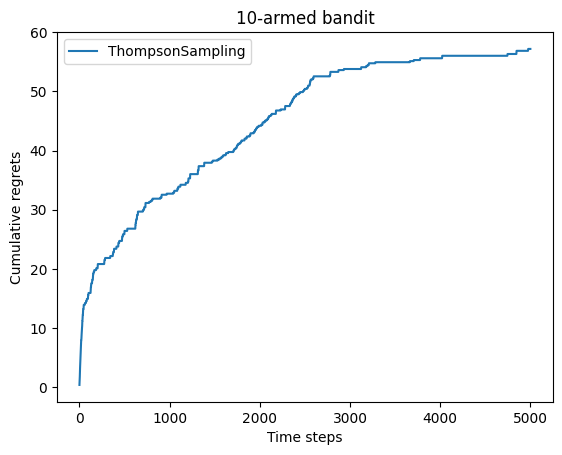

In [8]:
class ThompsonSampling(Solver):
  """ 汤普森采样算法,继承Solver类 """
  def __init__(self, bandit):
    super(ThompsonSampling, self).__init__(bandit)
    self._a = np.ones(self.bandit.K)
    self._b = np.ones(self.bandit.K)
    # 每根拉杆奖励为1/0的次数
    
  def run_one_step(self):
    samples = np.random.beta(self._a, self._b) # 按照Beta分布采样一组奖励
    k = np.argmax(samples) # 选出最大奖励的样本
    r = self.bandit.step(k)
    
    self._a[k] += r # 更新参数
    self._b[k] += (1 - r) 
    return k
  
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])